基于滑动窗口的数据处理
- 滑动窗口
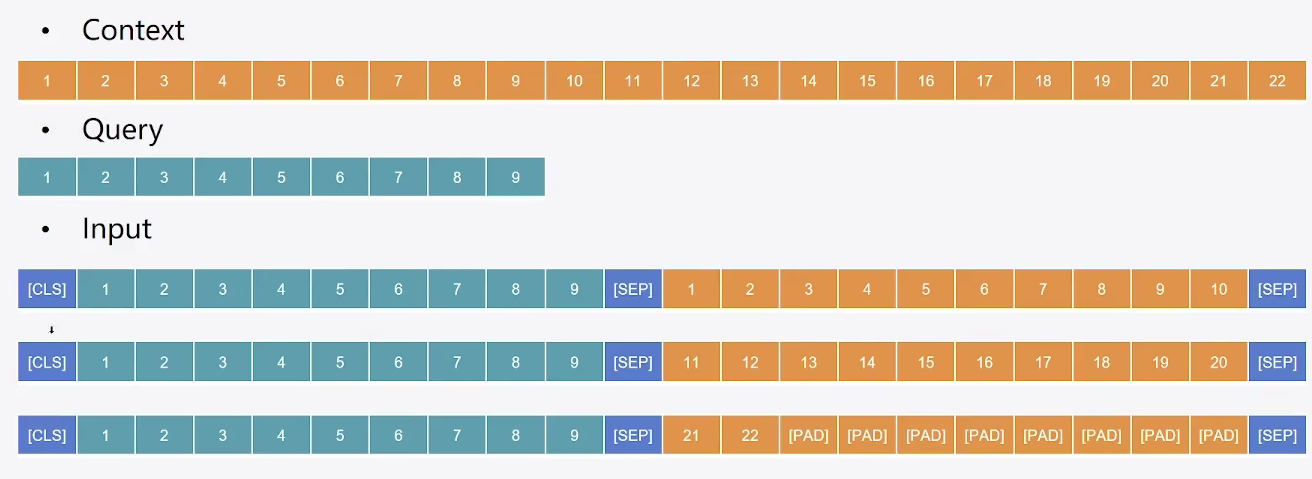

- 带有overflow的滑动窗口
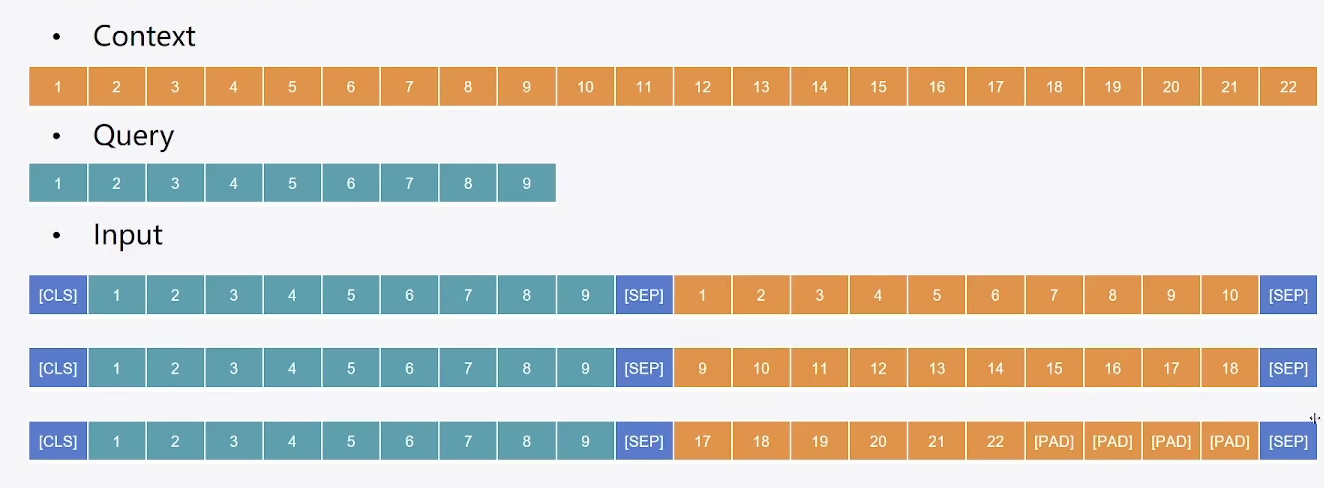

- 结果预测
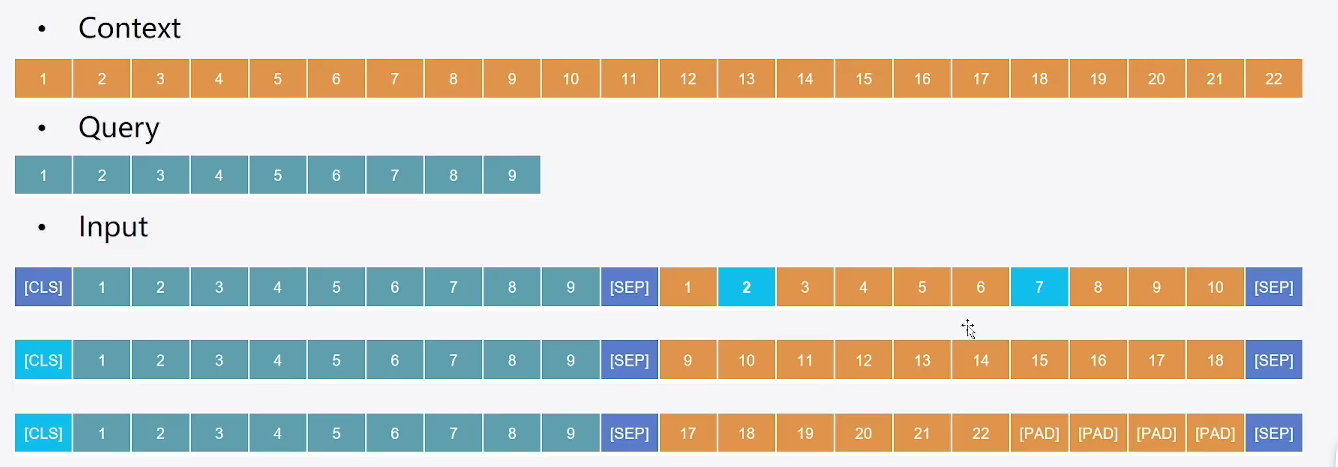

- 数据集
    - cmrc2018
- 预训练模型
    - hfl/chinese-macbert-base
- 数据集处理方式
    - 对context进行滑动窗口处理

- 相关包安装
    - pip install nltk
    - nltk.download('punkt')

#### Step1 导入相关包

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer,AutoModelForQuestionAnswering,TrainingArguments,Trainer,DefaultDataCollator

c:\Users\ningmeng\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Step2 数据加载

In [2]:
datasets=load_dataset('cmrc2018',cache_dir='data')

C:\Users\ningmeng\AppData\Roaming\Python\Python310\site-packages\datasets\load.py:1461: FutureWarning: The repository for cmrc2018 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/cmrc2018
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
datasets['train'][0]

{'id': 'TRAIN_186_QUERY_0',
 'context': '范廷颂枢机（，），圣名保禄·若瑟（），是越南罗马天主教枢机。1963年被任为主教；1990年被擢升为天主教河内总教区宗座署理；1994年被擢升为总主教，同年年底被擢升为枢机；2009年2月离世。范廷颂于1919年6月15日在越南宁平省天主教发艳教区出生；童年时接受良好教育后，被一位越南神父带到河内继续其学业。范廷颂于1940年在河内大修道院完成神学学业。范廷颂于1949年6月6日在河内的主教座堂晋铎；及后被派到圣女小德兰孤儿院服务。1950年代，范廷颂在河内堂区创建移民接待中心以收容到河内避战的难民。1954年，法越战争结束，越南民主共和国建都河内，当时很多天主教神职人员逃至越南的南方，但范廷颂仍然留在河内。翌年管理圣若望小修院；惟在1960年因捍卫修院的自由、自治及拒绝政府在修院设政治课的要求而被捕。1963年4月5日，教宗任命范廷颂为天主教北宁教区主教，同年8月15日就任；其牧铭为「我信天主的爱」。由于范廷颂被越南政府软禁差不多30年，因此他无法到所属堂区进行牧灵工作而专注研读等工作。范廷颂除了面对战争、贫困、被当局迫害天主教会等问题外，也秘密恢复修院、创建女修会团体等。1990年，教宗若望保禄二世在同年6月18日擢升范廷颂为天主教河内总教区宗座署理以填补该教区总主教的空缺。1994年3月23日，范廷颂被教宗若望保禄二世擢升为天主教河内总教区总主教并兼天主教谅山教区宗座署理；同年11月26日，若望保禄二世擢升范廷颂为枢机。范廷颂在1995年至2001年期间出任天主教越南主教团主席。2003年4月26日，教宗若望保禄二世任命天主教谅山教区兼天主教高平教区吴光杰主教为天主教河内总教区署理主教；及至2005年2月19日，范廷颂因获批辞去总主教职务而荣休；吴光杰同日真除天主教河内总教区总主教职务。范廷颂于2009年2月22日清晨在河内离世，享年89岁；其葬礼于同月26日上午在天主教河内总教区总主教座堂举行。',
 'question': '范廷颂是什么时候被任为主教的？',
 'answers': {'text': ['1963年'], 'answer_start': [30]}}

#### Step3 数据预处理

In [4]:
tokenizer=AutoTokenizer.from_pretrained('hfl/chinese-macbert-base')
tokenizer

BertTokenizerFast(name_or_path='hfl/chinese-macbert-base', vocab_size=21128, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [5]:
# 取10条数据
sample_dataset=datasets['train'].select(range(10))
sample_dataset

Dataset({
    features: ['id', 'context', 'question', 'answers'],
    num_rows: 10
})

In [15]:
tokenized_examples = tokenizer(
    text=sample_dataset['question'],          # 将问题文本标记化
    text_pair=sample_dataset['context'],      # 将上下文文本标记化
    return_offsets_mapping=True,              # 返回标记的偏移映射，用于后续定位标记在原始文本中的位置
    return_overflowing_tokens=True, # 返回超出最大长度的 tokens
    max_length=384,                           # 设置标记化后的最大长度为512
    truncation='only_second',                 # 仅在第二个文本（这里是上下文文本）进行截断
    padding=True,                              # 对标记化后的序列进行填充，使它们的长度一致
    stride=128,# 滑动窗口的步长为128
)
tokenized_examples.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

In [16]:
# 样本超过了10条
print(tokenized_examples['overflow_to_sample_mapping'],len(tokenized_examples['overflow_to_sample_mapping']))

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9] 29


In [17]:
# 发现前3条都是第一条样本的数据
for sen in tokenizer.batch_decode(tokenized_examples['input_ids'][:3]):
    print(sen)

[CLS] 范 廷 颂 是 什 么 时 候 被 任 为 主 教 的 ？ [SEP] 范 廷 颂 枢 机 （ ， ） ， 圣 名 保 禄 · 若 瑟 （ ） ， 是 越 南 罗 马 天 主 教 枢 机 。 1963 年 被 任 为 主 教 ； 1990 年 被 擢 升 为 天 主 教 河 内 总 教 区 宗 座 署 理 ； 1994 年 被 擢 升 为 总 主 教 ， 同 年 年 底 被 擢 升 为 枢 机 ； 2009 年 2 月 离 世 。 范 廷 颂 于 1919 年 6 月 15 日 在 越 南 宁 平 省 天 主 教 发 艳 教 区 出 生 ； 童 年 时 接 受 良 好 教 育 后 ， 被 一 位 越 南 神 父 带 到 河 内 继 续 其 学 业 。 范 廷 颂 于 1940 年 在 河 内 大 修 道 院 完 成 神 学 学 业 。 范 廷 颂 于 1949 年 6 月 6 日 在 河 内 的 主 教 座 堂 晋 铎 ； 及 后 被 派 到 圣 女 小 德 兰 孤 儿 院 服 务 。 1950 年 代 ， 范 廷 颂 在 河 内 堂 区 创 建 移 民 接 待 中 心 以 收 容 到 河 内 避 战 的 难 民 。 1954 年 ， 法 越 战 争 结 束 ， 越 南 民 主 共 和 国 建 都 河 内 ， 当 时 很 多 天 主 教 神 职 人 员 逃 至 越 南 的 南 方 ， 但 范 廷 颂 仍 然 留 在 河 内 。 翌 年 管 理 圣 若 望 小 修 院 ； 惟 在 1960 年 因 捍 卫 修 院 的 自 由 、 自 治 及 拒 绝 政 府 在 修 院 设 政 治 课 的 要 求 而 被 捕 。 1963 年 4 月 5 日 ， 教 宗 任 命 范 廷 颂 为 天 主 教 北 宁 教 区 主 教 ， 同 年 8 月 15 日 就 任 ； 其 牧 铭 为 「 我 信 [SEP]
[CLS] 范 廷 颂 是 什 么 时 候 被 任 为 主 教 的 ？ [SEP] 越 南 民 主 共 和 国 建 都 河 内 ， 当 时 很 多 天 主 教 神 职 人 员 逃 至 越 南 的 南 方 ， 但 范 廷 颂 仍 然 留 在 河 内 。 翌 年 管 理 圣 若 望 小 修 院 ； 惟 在 1960 年 因 捍 卫 修 院 的 自 由 、 自 治 及 拒 

In [19]:
print(tokenized_examples['offset_mapping'][:3])

[[(0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (41, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (59, 60), (60, 61), (61, 62), (62, 63), (63, 67), (67, 68), (68, 69), (69, 70), (70, 71), (71, 72), (72, 73), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (82, 83), (83, 84), (84, 85), (85, 86), (86, 87), (87, 91), (91, 92), (92, 93), (93, 94), (94, 95), (95, 96), (96, 97), (97, 98), (98, 99), 

#### Step4 加载模型